In [1]:
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from lib.densenet import DenseNet
import numpy as np
import os
from utils import Dotdict
import json
from skimage.transform import resize

/home/thallessilva/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import dlib
detector = dlib.get_frontal_face_detector()

In [3]:
arthur1="https://scontent.fgru3-1.fna.fbcdn.net/v/t1.0-9/17798987_1302094279873870_4453819690122481931_n.jpg?_nc_cat=0&oh=3f7cd4c6cdc767cbbe9fbce1fd13f217&oe=5C1C57C1"
ari1 = "https://scontent.fgru3-1.fna.fbcdn.net/v/t1.0-9/35886923_1585067994931082_1067892701313105920_n.jpg?_nc_cat=0&oh=3c9e0b55323ea957589e991a71feeeaf&oe=5C302470"
ari2 = "https://scontent.fgru3-1.fna.fbcdn.net/v/t1.0-9/31542726_1531214610316421_8819293200766283668_n.jpg?_nc_cat=0&oh=31c01a284d80959d762a2b4882a71f98&oe=5C25CF86"
nathy="https://scontent.fgru3-1.fna.fbcdn.net/v/t1.0-9/10455644_809278375749090_913157140548018995_n.jpg?_nc_cat=0&oh=e4d7af538c74fe4c12ff18c838bde820&oe=5C389A60"
thalles1="https://scontent.fgru3-1.fna.fbcdn.net/v/t1.0-9/27658136_1581150235295015_3486959609797495552_n.jpg?_nc_cat=0&oh=db04e879e804f5aa209b6e61572d2970&oe=5C2B9747"
thalles2="https://scontent.fgru3-1.fna.fbcdn.net/v/t31.0-8/477294_268615906548461_1589687343_o.jpg?_nc_cat=0&oh=405e287df858dba39f10ac016785434b&oe=5C38F5E6"

In [4]:
image1 = imageio.imread(thalles2)
image2 = imageio.imread(arthur1)

print(image1.shape, image2.shape)

(1937, 1506, 3) (960, 958, 3)


In [5]:
def detect_crop_and_resize(image1, output_shape=(128,128,3)):
    dets = detector(image1, 1)
    print("Number of faces detected: {}".format(len(dets)))
    for i, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            i, d.left(), d.top(), d.right(), d.bottom()))

        width = d.right() - d.left()
        height = d.bottom() - d.top()
        
        if width > height:
            height = width
        else:
            width = height
        
        x, y = d.top(), d.left()
        
        increase_factor = 0.8
        increase = int(increase_factor * height)
        print("Old height:", height, "New height:", height+increase)
        margin = increase // 2
        
        increment = margin // 4
        cropped_face = image1[x-margin:x+height+margin, y-margin:y+width+margin,]
        cropped_face = resize(cropped_face, output_shape)
        plt.imshow(cropped_face)
        plt.show()
        return cropped_face

Number of faces detected: 2
Detection 0: Left: 356 Top: 418 Right: 911 Bottom: 973
Old height: 555 New height: 999


/home/thallessilva/.virtualenvs/cv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/thallessilva/.virtualenvs/cv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


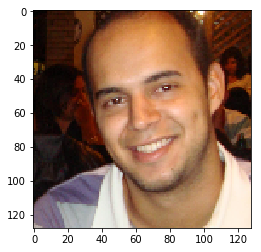

Number of faces detected: 1
Detection 0: Left: 349 Top: 350 Right: 617 Bottom: 617
Old height: 268 New height: 482


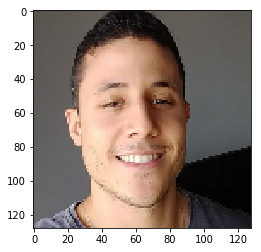

In [6]:
image1 = detect_crop_and_resize(image1)
image2 = detect_crop_and_resize(image2)

In [7]:
# print(np.max(image1), np.min(image1))
# plt.imshow(image1)
# plt.show()

In [8]:
# print(np.max(image2), np.min(image1))
# plt.imshow(image2)
# plt.show()

In [9]:
Xi = np.expand_dims(image1,0).astype(np.float32)
Xj = np.expand_dims(image2,0).astype(np.float32)

In [10]:
def normalize(Xi):
    return 2 * (Xi - 0.5)

def denormalize(Xi):
    return (Xi / 2 ) + 0.5

In [11]:
checkpoint_dir = "./tboard_logs"
model_id = "31911"
checkpoint_dir = os.path.join(checkpoint_dir, model_id)

# load training metadata
with open(checkpoint_dir + '/meta.json', 'r') as fp:
    training_args = Dotdict(json.load(fp))

args = {"k": training_args.growth_rate,
        "weight_decay": training_args.l2_regularization,
        "num_outputs": training_args.num_outputs,
        "units_per_block": training_args.units_per_block,
        "momentum": training_args.momentum,
        "epsilon": training_args.epsilon,
        "initial_pool": training_args.initial_pool}
print(args)

{'k': 32, 'weight_decay': 0.01, 'num_outputs': 32, 'units_per_block': [6, 12, 24, 16], 'momentum': 0.997, 'epsilon': 0.001, 'initial_pool': True}


In [12]:
model = DenseNet(**args)

checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint('/home/thallessilva/workspace/face-similarity/tboard_logs/31911/saved_model'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [13]:
eps = 1e-7
GX1 = model(tf.constant(normalize(Xi)), training=False)
GX2 = model(tf.constant(normalize(Xj)), training=False)
Dw = tf.sqrt(eps + tf.reduce_sum(tf.square(GX1 - GX2), 1))

Similariry: [1.1098964]


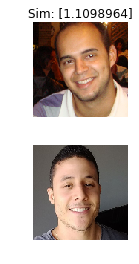

In [14]:
with tf.Session() as session:
    # Use the Session to restore variables, or initialize them if
    # tf.train.latest_checkpoint returned None.
    status.run_restore_ops(session)
    distance = session.run(Dw)
    
    f, axarr = plt.subplots(2, 1, figsize=(16,4))
    f.subplots_adjust(hspace=0.3)
    
    axarr[0].set_title('Sim: ' + str(distance))
    print('Similariry: ' + str(distance))
    axarr[0].imshow(np.squeeze(Xi))
    axarr[0].set_axis_off()
    
    axarr[1].imshow(np.squeeze(Xj))
    axarr[1].set_axis_off()